In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pydot
import os
from fnmatch import fnmatch
from typing import Tuple, Dict, List
from tqdm.notebook import tqdm

# First param is project name, second is config name
LOCATION = "..\\out\\%s\\%s.csv"
# Params are project, datapoint, concepts
DATAPOINT = "..\\data\\corpora_clean\\%s\\%s\\%d\\merged.dot"
sns.set_style("whitegrid")
figsize=(5,4)
dpi=300
palette="dark"
# Fix plot fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# This filters all methods to the least common denominator
# Statistical tests ignore this setting and always ensure the same subset of points
# on pair-wise tests to ensure that the test is valid.
filter_to_common_points = False
add_graph_size = True
save_json = False
if add_graph_size:
    import jsonpickle

In [2]:
projects = [
    "Commandline",
    "CommonMark",
    "Hangfire",
    "Humanizer",
    "Lean",
    "Nancy",
    "Newtonsoft.Json",
    "Ninject",
    "RestSharp",
]

nice_name_to_config_name = {
    "Barnett et al.":"du_results_raw",
    "Herzig et al.":"bl_results_fd_cd_d_ns_cc_",
    "δ-PDG + CV":"bl_graph_results",
    "Heddle (δ-NFG + WL)":"wl_all_1_results_raw",
}

color_map = [
    'darkblue', 
    'brown',
    'brown', 
    'darkgreen',
]

methods_considered = list(nice_name_to_config_name.keys())

In [3]:
# Helper Functions to read the graphs, used to get graph size and change size statistics
if add_graph_size:
    def read_graph_from_dot(file_: str) -> Tuple[Dict, Dict[str, str]]:
        try:
            apdg = pydot.graph_from_dot_file(file_)[0].obj_dict
        except (IndexError, AttributeError, RuntimeError, TypeError, ValueError):
            apdg = ""
        return apdg

    def obj_dict_to_networkx(obj_dict: Tuple[Dict, Dict[str, str]]) -> nx.MultiDiGraph:
        graph = nx.MultiDiGraph()

        if isinstance(obj_dict, str):
            return graph

        for node, data in list(obj_dict['nodes'].items()):
            if node != 'graph' and 'span' in data[0]['attributes'].keys():
                attr = {k: v[1:-1] if v[0] == v[-1] == '"' else v for k, v in data[0]['attributes'].items()}
                graph.add_node(node, **attr)

        for edge, data in list(obj_dict['edges'].items()):
            s, t = edge
            attr = {k: v[1:-1] if v[0] == v[-1] == '"' else v for k, v in data[0]['attributes'].items()}
            graph.add_edge(s, t, **attr)

        for subgraph in list(obj_dict['subgraphs'].keys()):
            for node, data in list(obj_dict['subgraphs'][subgraph][0]['nodes'].items()):
                if node != 'graph' and 'span' in data[0]['attributes'].keys():
                    attr = {k: v[1:-1] if v[0] == v[-1] == '"' else v for k, v in data[0]['attributes'].items()}
                    if 'label' in obj_dict['subgraphs'][subgraph][0]['attributes'].keys():
                        attr['cluster'] = obj_dict['subgraphs'][subgraph][0]['attributes']['label'][1:-1]
                    elif 'graph' in obj_dict['subgraphs'][subgraph][0]['nodes'].keys():
                        attr['cluster'] = obj_dict['subgraphs'][subgraph][0]['nodes']['graph'][0]['attributes']['label'][1:-1]
                    graph.add_node(node, **attr)

        return graph

In [4]:
# Classes to either get data from a JSON, Memory, or read/generate it from the corpus
if add_graph_size:
    class SizeFromGraph(object):
        def __init__(self,):
            self.size_lookup = dict()
            try:
                with open('./size_lookup.json') as f:
                    temp = jsonpickle.loads(f.read())
                    for key in temp.keys():
                        self.size_lookup[eval(key)] = temp[key]
            except FileNotFoundEror:
                pass

        def __call__(self, project: str, datapoint: str, concepts: str) -> int:
            if (project, datapoint, concepts) in self.size_lookup.keys():
                return self.size_lookup[(project, datapoint, concepts)]
            else:
                try:
                    size = len(obj_dict_to_networkx(
                        read_graph_from_dot(DATAPOINT % (project, datapoint, concepts))).nodes())
                    self.size_lookup[(project, datapoint, concepts)] = size
                except FileNotFoundError:
                    return float('nan')
                return size
    
    class ChangedFromGraph(object):
        def __init__(self,):
            self.change_lookup = dict()
            try:
                with open('./change_lookup.json') as f:
                    temp = jsonpickle.loads(f.read())
                    for key in temp.keys():
                        self.change_lookup[eval(key)] = temp[key]
            except FileNotFoundError:
                pass

        def __call__(self, project: str, datapoint: str, concepts: str) -> int:
            if (project, datapoint, concepts) in self.change_lookup.keys():
                return self.change_lookup[(project, datapoint, concepts)]
            else:
                try:
                    delta = obj_dict_to_networkx(
                        read_graph_from_dot(DATAPOINT % (project, datapoint, concepts)))
                    size = len([n for n, d in delta.nodes(data=True)
                                 if 'color' in d.keys() 
                                 and d['color'] != 'orange' 
                                 and 'community' in d.keys()])
                    self.change_lookup[(project, datapoint, concepts)] = size
                except FileNotFoundError:
                    return float('nan')
                return size

In [5]:
if add_graph_size:    
    sizeLookAside = SizeFromGraph()
    changedLookAside = ChangedFromGraph()

    # Prepopulate cache
    def get_pattern_paths(pattern: str, path: str) -> List[str]:
        """
        Find the OS paths to all files that match a pattern
        :param pattern: The regEx pattern to match the filename to
        :param path: The path where we should search for files
        :return: A list of paths to the found files,
        empty list when no files found
        """
        files_paths = []
        for subpath, subdirs, files in os.walk(path):
            for name in files:
                if fnmatch(name, pattern):
                    files_paths.append(os.path.join(subpath, name))
        return files_paths

    for graph_location in tqdm(get_pattern_paths('*merged.dot', "G:\\recovered_from_cluster\\yarn\\data\\corpora_clean")):
        try:
            project = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(graph_location))))
            chain = os.path.basename(os.path.dirname(os.path.dirname(graph_location)))
            q = int(os.path.basename(os.path.dirname(graph_location)))
            sizeLookAside(project, chain, q)
            changedLookAside(project, chain, q)
        except FileNotFoundError:
            pass

In [6]:
# We don't want to waste time regenerating data if we've done it once
if add_graph_size and save_json:
    with open('./size_lookup.json', 'w') as f:
        f.write(jsonpickle.dumps(sizeLookAside.size_lookup))
    with open('./change_lookup.json', 'w') as f:
        f.write(jsonpickle.dumps(changedLookAside.change_lookup))

In [7]:
# Bring all results into a single DataFrame View
df = pd.DataFrame(data=[], columns=['Datapoint','Concepts','Accuracy','Overlap','Time'])
for method in methods_considered:
    for project in projects:
        try:
            temp_df = pd.read_csv(LOCATION % (project, nice_name_to_config_name[method]),
                                  index_col=False)
            # Due to Barnett et al. working only on added lines, we need to consider Cover
            # i.e. to what degree was it applicable to the problem as well
            if method == "Barnett et al.":
                # Note that this means that Barnett et al automatically gets deleted
                # lines wrong by default
                temp_df["Accuracy"] = temp_df["Accuracy"] * temp_df["Cover"]
                temp_df["Accuracy"] = temp_df["Accuracy"].fillna(0)
                # If we don't drop it before merging, we add a lot of NANs for all methods
                # except Barnett et al.
                temp_df = temp_df.drop(["Cover"], axis=1)
            # We want to keep track of what method and project the data originates from
            temp_df['Project'] = pd.Series([project]*len(temp_df.index))
            temp_df['Method'] = pd.Series([method]*len(temp_df.index))
            df = df.append(temp_df, sort=False)
        except FileNotFoundError:
            pass # If it's not there, it's not there yet :)

# We drop results where a method was not applicable (Accuracy is NAN)
df = df[df.Accuracy.notna()]
# Sadly we have too few examples of succesful 4-commit-tangles for results
# to be statistically meaningful (len(df[df.Concepts == 4]) == 10)
df = df[df.Concepts < 4]

# This avoid a div by 0 later, but this also means we have to manually set the ylim in plots
df["Time"] = df.apply(lambda row: row["Time"] if row["Time"] > 0 else row["Time"] + 1e-31, 
                      axis=1)

# We add information about size and change size here for run-time regressions
if add_graph_size:
    df["Size"] = df.apply(lambda row: sizeLookAside(row["Project"], 
                                                    row["Datapoint"], 
                                                    row["Concepts"]),axis=1)
    df["Change Size"] = df.apply(lambda row: changedLookAside(row["Project"], 
                                                           row["Datapoint"], 
                                                           row["Concepts"]),axis=1)

In [8]:
if filter_to_common_points:
    # This optionally allows us to study a what if scenario where all methods must run
    # on all points. This drastically reduces the corpus but simplifies statistical tests.
    #
    # Regardless of this option, statistical tests filter to common points for each pair of
    # tests between methods to ensure a fair comparison.
    #
    datapoints = list()
    for method in methods_considered:
        datapoints.append(list(df[df.Method == method].Datapoint))
    common_points = set(datapoints[0])
    for dp in datapoints[1:]:
        if len(dp) > 0:
            common_points = common_points.intersection(set(dp))
    df = df[df.Datapoint.isin(common_points)]
df.index = range(len(df.index))
df

,Datapoint,Concepts,Accuracy,Overlap,Time,Project,Method,Size,Change Size
0,c3279f2ff609f648446b021b4578a2570fe03c78_05fe6...,2,0.500000,1.000000,6.250000e-03,Commandline,Barnett et al.,44.0,2.0
1,01c822cc47aece632138749be6de82c4978a4253_14b00...,1,0.400000,0.200000,2.343750e-02,Commandline,Barnett et al.,168.0,5.0
2,ff0da0b60a46ebe317cd3e548863294a455a632e_acea7...,2,0.000000,NaN,5.156250e-02,Commandline,Barnett et al.,314.0,7.0
3,45b9a8dfc2bc5ae48b6715dfefbe46a6bff1467d_c7138...,2,0.000000,NaN,1.000000e-31,Commandline,Barnett et al.,1107.0,844.0
4,8aeaf27de33667afb150c5234348df317f8216e0_28be1...,1,0.166667,0.161647,4.381250e+00,Commandline,Barnett et al.,281.0,168.0
...,...,...,...,...,...,...,...,...,...
11478,46d85b6151161928eea541c3dd1923f4523f9f0c_4ffcc...,1,0.473563,0.368276,2.997111e+02,RestSharp,Heddle (δ-NFG + WL),1086.0,435.0
11479,6d753671d352828d9ba0729aad611938db6f2273_ed589...,2,0.951724,0.927586,1.318711e+02,RestSharp,Heddle (δ-NFG + WL),8188.0,290.0
11480,ca961deb317d659970067d8834b0d94c5a3d4dd8_12d28...,2,0.761905,0.523810,9.979203e+00,RestSharp,Heddle (δ-NFG + WL),1491.0,84.0
11481,038980002c5a5fad715eca490a39e56a128423fc_95894...,2,0.805556,0.708333,9.031086e+00,RestSharp,Heddle (δ-NFG + WL),2226.0,72.0


In [9]:
# We use wl_df.Concepts == 1 to judge if our tool over-segments
wl_df = df[df.Method == "Heddle (δ-NFG + WL)"]
print('Correctly atomic:')
print('%1.4f' % (sum(wl_df[wl_df.Concepts == 1].Overlap.isnull()) / len(wl_df[wl_df.Concepts == 1])))
print('Atomic graph labelling accuracy:')
print('%1.4f' % wl_df[wl_df.Concepts == 1].Accuracy.mean())

Correctly atomic:
0.6277
Atomic graph labelling accuracy:
0.9261


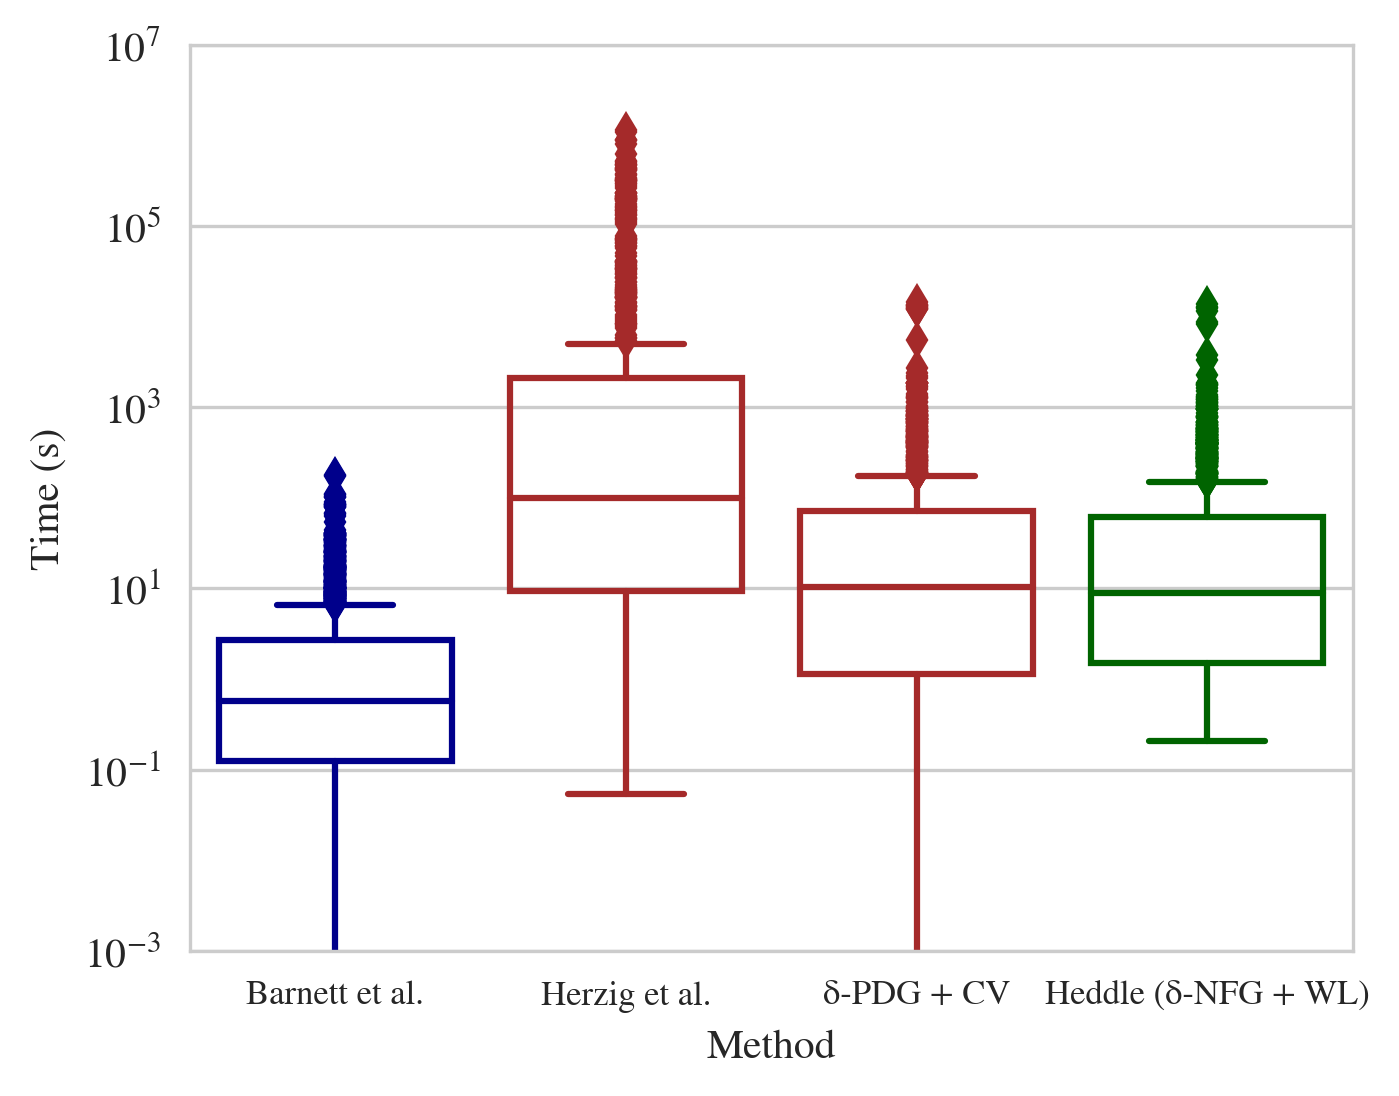

In [10]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.gca()
sns.boxplot(data=df[df.Concepts > 1], x="Method", y="Time", palette=palette, ax=ax)
plt.yscale('log')

# This just makes the boxplots look nicer
for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = color_map[i]
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

plt.ylabel("Time (s)")
        
plt.xticks(
    horizontalalignment='center',
    fontweight='light',
    fontsize='small',
)

# This takes care of artificially inserted machine epsilons that avoid div by 0 later
plt.ylim((1e-3, 1e7))

plt.savefig("Time.pdf", 
            #This is simple recomendation for publication plots
            dpi=1000, 
            # Plot will be occupy a maximum of available space
            bbox_inches='tight', 
           )

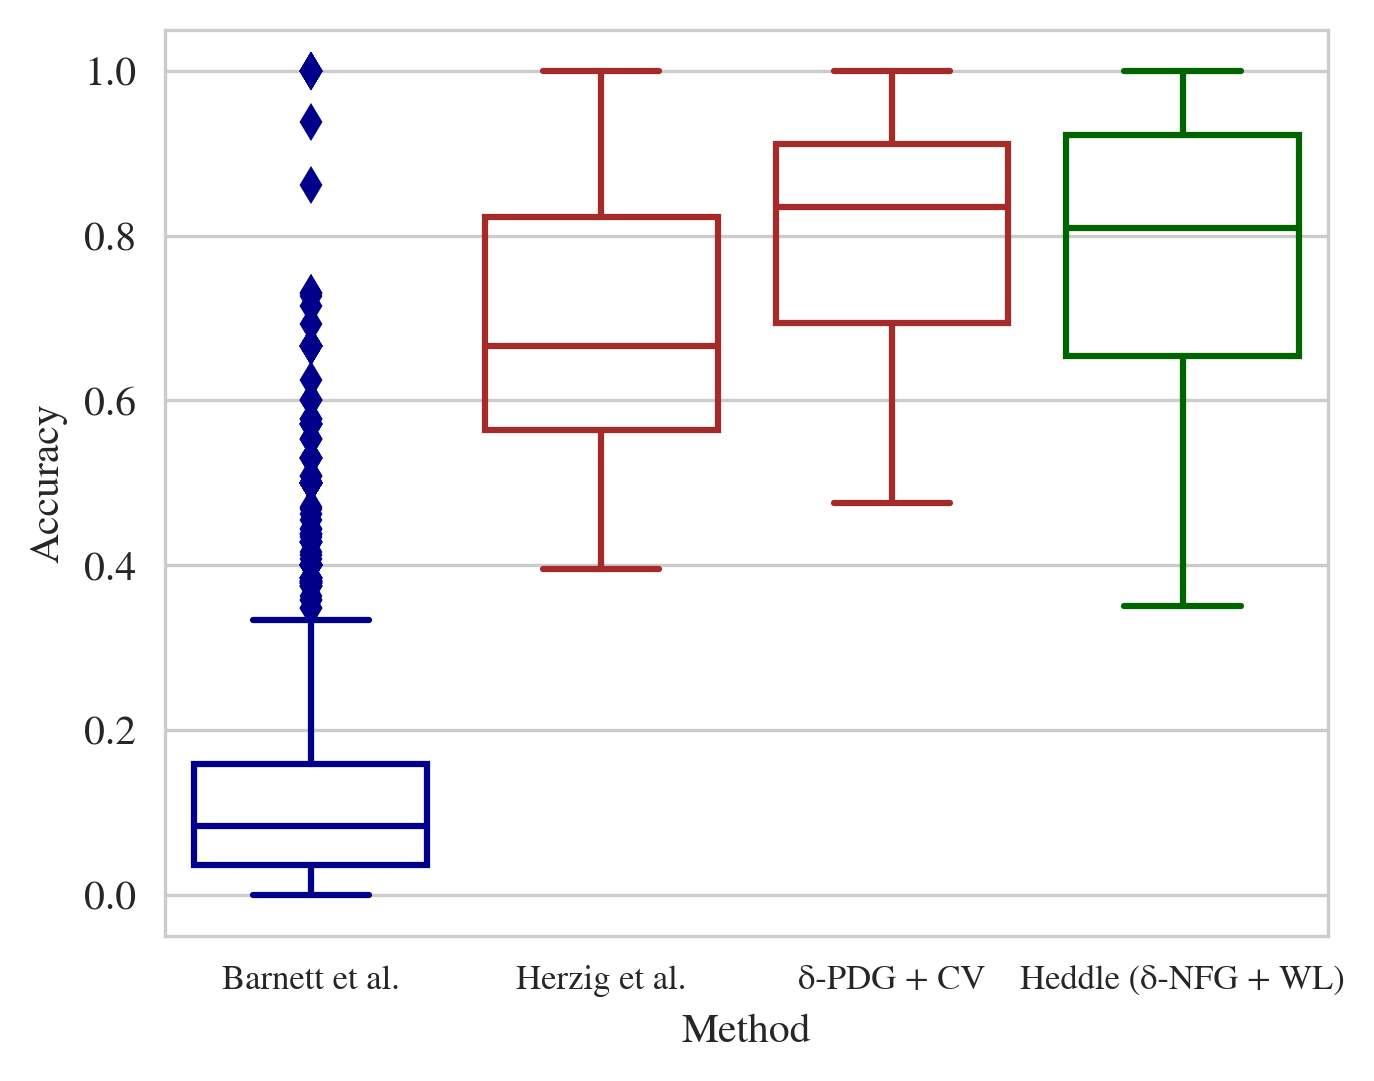

In [11]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.gca()
sns.boxplot(data=df[df.Concepts > 1], x="Method", y="Accuracy", palette=palette, ax=ax)

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = color_map[i]
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

plt.xticks(
    horizontalalignment='center',
    fontweight='light',
    fontsize='small',
)
    
plt.savefig("Accuracy.pdf", 
            #This is simple recomendation for publication plots
            dpi=1000, 
            # Plot will be occupy a maximum of available space
            bbox_inches='tight', 
           )

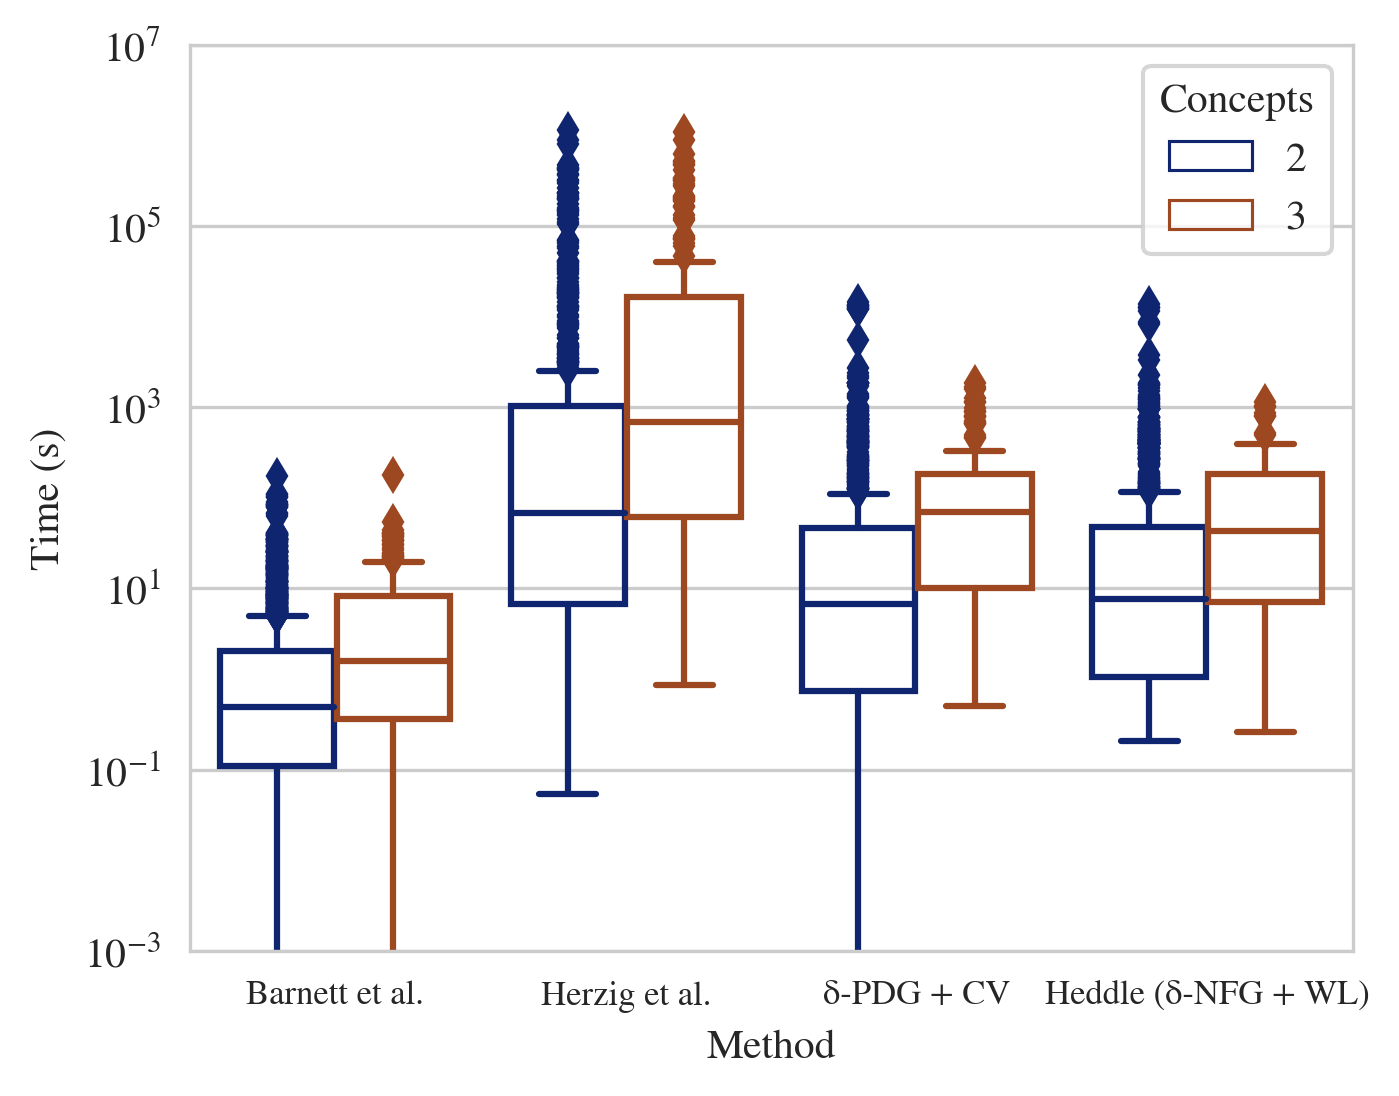

In [12]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.gca()
sns.boxplot(data=df[df.Concepts > 1], x="Method", y="Time", hue="Concepts", palette=palette, ax=ax)

plt.yscale('log')

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# Also fix the legend
for legpatch in ax.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')

plt.ylabel("Time (s)")
    
plt.xticks(
    horizontalalignment='center',
    fontweight='light',
    fontsize='small',
)

plt.ylim((1e-3, 1e7))
    
plt.savefig("Time_by_concepts.pdf", 
            #This is simple recomendation for publication plots
            dpi=1000, 
            # Plot will be occupy a maximum of available space
            bbox_inches='tight', 
           )

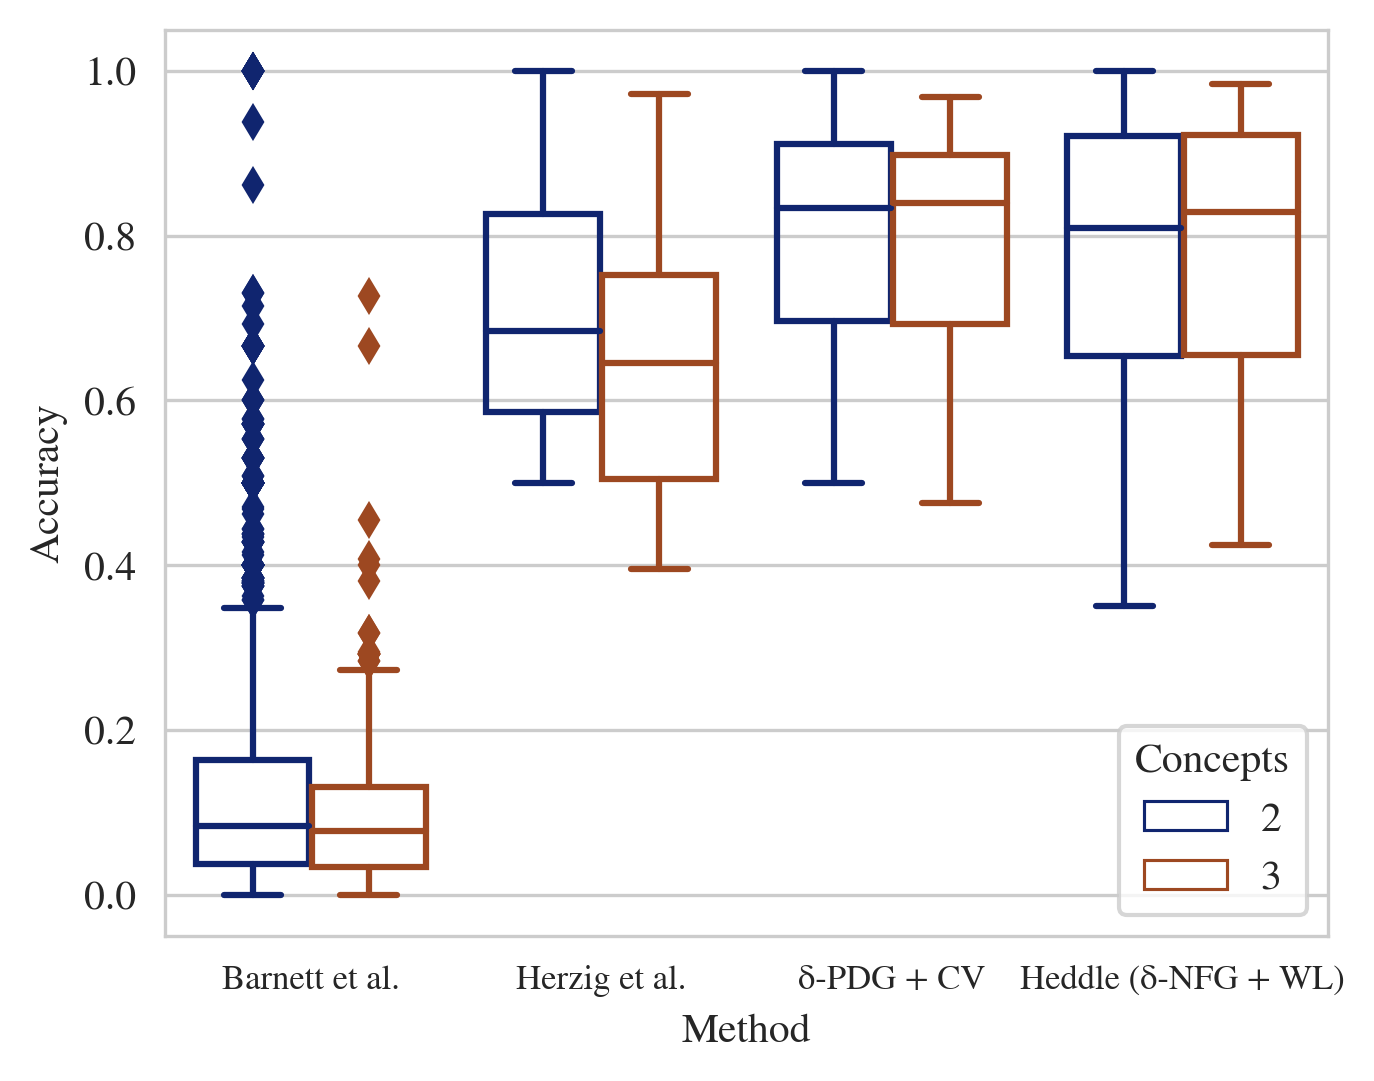

In [13]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = fig.gca()
sns.boxplot(data=df[df.Concepts > 1], x="Method", y="Accuracy", hue="Concepts", palette=palette, ax=ax)

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# Also fix the legend
for legpatch in ax.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')

plt.xticks(
    horizontalalignment='center',
    fontweight='light',
    fontsize='small',
)
    
plt.savefig("Accuracy_by_concepts.pdf", 
            #This is simple recomendation for publication plots
            dpi=1000, 
            # Plot will be occupy a maximum of available space
            bbox_inches='tight', 
           )

In [14]:
# Barnett was one of the quickest methods to run, thus has all datapoints
# We can use this to generate corpus statistics
stats_df = pd.DataFrame(columns=["Project", "Concepts", "Count"], 
                        index=np.arange(0, (len(projects) + 1) * 4))

view_df = df[df.Method == "Barnett et al."]
for i, project in enumerate(projects):
    view = view_df[view_df.Project == project]
    stats_df.iloc[i*4] = [project, -1, len(view[view.Concepts > 1])]
    for j, c in enumerate([2,3,4]):
        stats_df.iloc[i*4 + j + 1] = [project, c, len(view[view.Concepts == c])]

i = len(projects)
stats_df.iloc[i*4] = ["Overall", -1, len(view_df[view_df.Concepts > 1])]
for j, c in enumerate([2,3,4]):
    stats_df.iloc[i*4 + j + 1] = ["Overall", c, len(view_df[view_df.Concepts == c])]

stats_df.to_csv('stats.csv', index=False)
stats_df

,Project,Concepts,Count
0,Commandline,-1,372
1,Commandline,2,335
2,Commandline,3,37
3,Commandline,4,0
4,CommonMark,-1,52
5,CommonMark,2,52
6,CommonMark,3,0
7,CommonMark,4,0
8,Hangfire,-1,386
9,Hangfire,2,282


In [15]:
# Note here that -1 will represent All concepts/Overall
results_df = df[df.Concepts > 1].drop(["Size", "Change Size", "Overlap"],axis=1).copy()
for method in methods_considered:
    temp_df = results_df[results_df.Method == method].drop(["Project"], axis = 1)
    temp_df.index = range(len(temp_df.index))
    temp_df['Project'] = pd.Series(["Overall"]*len(temp_df.index), index=temp_df.index)
    results_df = results_df.append(temp_df, ignore_index=True, sort=False)
    
    temp_df = results_df[results_df.Method == method].drop(["Concepts"], axis = 1)
    temp_df.index = range(len(temp_df.index))
    temp_df['Concepts'] = pd.Series([-1]*len(temp_df.index))
    results_df = results_df.append(temp_df, ignore_index=True, sort=False)
    
results_df

,Datapoint,Concepts,Accuracy,Time,Project,Method
0,c3279f2ff609f648446b021b4578a2570fe03c78_05fe6...,2,0.500000,6.250000e-03,Commandline,Barnett et al.
1,ff0da0b60a46ebe317cd3e548863294a455a632e_acea7...,2,0.000000,5.156250e-02,Commandline,Barnett et al.
2,45b9a8dfc2bc5ae48b6715dfefbe46a6bff1467d_c7138...,2,0.000000,1.000000e-31,Commandline,Barnett et al.
3,01d30c3f3769f9052cdf940c6aebe6a879eb2274_1b27c...,2,0.166667,8.125000e-02,Commandline,Barnett et al.
4,c3279f2ff609f648446b021b4578a2570fe03c78_f0cb2...,2,0.166667,9.687500e-02,Commandline,Barnett et al.
...,...,...,...,...,...,...
20059,2e7566d2c39dd107b4eacb1845a028d4fffd36a9_52ec3...,-1,0.959184,1.422025e+01,Overall,Heddle (δ-NFG + WL)
20060,6d753671d352828d9ba0729aad611938db6f2273_ed589...,-1,0.951724,1.318711e+02,Overall,Heddle (δ-NFG + WL)
20061,ca961deb317d659970067d8834b0d94c5a3d4dd8_12d28...,-1,0.761905,9.979203e+00,Overall,Heddle (δ-NFG + WL)
20062,038980002c5a5fad715eca490a39e56a128423fc_95894...,-1,0.805556,9.031086e+00,Overall,Heddle (δ-NFG + WL)


In [16]:
results = results_df.groupby(["Method", "Project", "Concepts"]).median()
results.round(3).to_csv('results.csv')
# This ensures we will see all results here as well
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)
results

Accuracy                 Time
Method              Project         Concepts                                          
Barnett et al.      Commandline     -1                       0.11                 0.09
                                     2                       0.11                 0.08
                                     3                       0.07                 8.57
                    CommonMark      -1                       0.13                 0.58
                                     2                       0.13                 0.58
                    Hangfire        -1                       0.10                 0.68
                                     2                       0.10                 0.52
                                     3                       0.11                 1.70
                    Humanizer       -1                       0.09                 0.11
                                     2                       0.09                 0.11
                                     3                       0.11                 0.04
                    Lean            -1                       0.08                 0.78
                                     2                       0.08                 0.74
                                     3                       0.09                 1.43
                    Nancy           -1                       0.05                 1.06
                                     2                       0.05                 0.90
                                     3                       0.04                 2.08
                    Newtonsoft.Json -1                       0.12                 1.25
                                     2                       0.12                 1.30
                                     3                       0.09                 0.95
                    Ninject         -1                       0.08                 0.62
                                     2                       0.08                 0.62
                    Overall         -1                       0.08                 0.57
                                     2                       0.08                 0.49
                                     3                       0.08                 1.59
                    RestSharp       -1                       0.11                 0.57
                                     2                       0.11                 0.65
                                     3                       0.11                 0.22
Heddle (δ-NFG + WL) Commandline     -1                       0.82                 1.05
                                     2                       0.82                 0.85
                                     3                       0.92               182.62
                    CommonMark      -1                       0.70                14.95
                                     2                       0.70                14.95
                    Hangfire        -1                       0.79                11.64
                                     2                       0.86                 8.06
                                     3                       0.68                45.29
                    Humanizer       -1                       0.82                 4.58
                                     2                       0.83                 4.86
                                     3                       0.57                 2.56
                    Lean            -1                       0.80                18.23
                                     2                       0.77                18.07
                                     3                       0.82                24.07
                    Nancy           -1                       0.86                20.92
                                     2                       0.81                16.52
                                     3                 

In [17]:
# Now we reset so that we don't get overwhealmed with output
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.float_format')
pd.reset_option('display.max_colwidth')

In [18]:
import itertools
from scipy.stats import mannwhitneyu, wilcoxon
for m1, m2 in itertools.combinations(methods_considered, 2):
    datapoints = list()
    for method in [m1, m2]:
        datapoints.append(list(zip(df[df.Method == method].Datapoint, df[df.Method == method].Concepts)))
    common_points = set(datapoints[0])
    for dp in datapoints[1:]:
        common_points = common_points.intersection(set(dp))
    common_points = ["%s_%d" % p for p in common_points]
    view_df = df[(df.Method == m1)|(df.Method == m2)].drop(["Overlap", "Size", "Change Size"],axis=1)
    view_df["Datapoint"] = view_df.apply(lambda row: row["Datapoint"] + "_" + str(row["Concepts"]),
                                         axis=1)
    view_df = view_df[view_df.Datapoint.isin(common_points)]
    view_df = view_df[view_df.Concepts > 1]
    view_df = view_df.drop_duplicates(["Method", "Datapoint", "Concepts"])
    try:
        print("%s vs %s, Accuracy, Wilcoxon signed-rank test" % (m1, m2))
        print(
            wilcoxon(view_df[view_df.Method == m1].Accuracy, view_df[view_df.Method == m2].Accuracy,
                        alternative='two-sided')
        )
        print("%s vs %s, Time, Wilcoxon signed-rank test" % (m1, m2))
        print(
            wilcoxon(view_df[view_df.Method == m1].Time, view_df[view_df.Method == m2].Time,
                        alternative='two-sided')
        )
    except ValueError:
        print("Overlap is 0 for %s vs %s" % (m1, m2))
    ratios = list()
    for dp in common_points:
        pairwise_view_df = view_df[view_df.Datapoint == dp]
        pairwise_view_df.index = range(len(pairwise_view_df.index))
        try:
            ratios.append(pairwise_view_df[pairwise_view_df.Method == m1].Time.iloc[0] / 
                          pairwise_view_df[pairwise_view_df.Method == m2].Time.iloc[0])
        except IndexError:
            pass
    ratio = np.nanmedian(np.asarray(ratios))
    if ratio > 1.0:
        print('%s is faster than %s' % (m2, m1))
        print('Pairwise ratio, Time: %2.3fx' % ratio)
    else:
        print('%s is faster than %s' % (m1, m2))
        print('Pairwise ratio, Time: %2.3fx' % (1/ratio))
    diffs = list()
    for dp in common_points:
        pairwise_view_df = view_df[view_df.Datapoint == dp]
        pairwise_view_df.index = range(len(pairwise_view_df.index))
        try:
            diffs.append(pairwise_view_df[pairwise_view_df.Method == m1].Time.iloc[0] - 
                          pairwise_view_df[pairwise_view_df.Method == m2].Time.iloc[0])
        except IndexError:
            pass
    print('Pairwise difference, Time: %2.3f seconds' % np.nanmedian(np.asarray(diffs)))
    print()

Barnett et al. vs Herzig et al., Accuracy, Wilcoxon signed-rank test
WilcoxonResult(statistic=134.0, pvalue=9.711317802322207e-63)
Barnett et al. vs Herzig et al., Time, Wilcoxon signed-rank test
WilcoxonResult(statistic=2003.0, pvalue=1.9917040932995029e-56)
Barnett et al. is faster than Herzig et al.
Pairwise ratio, Time: 690.389x
Pairwise difference, Time: -272.226 seconds

Barnett et al. vs δ-PDG + CV, Accuracy, Wilcoxon signed-rank test
WilcoxonResult(statistic=272.5, pvalue=2.0876997018200093e-153)
Barnett et al. vs δ-PDG + CV, Time, Wilcoxon signed-rank test
WilcoxonResult(statistic=53815.0, pvalue=6.793811465102931e-88)
Barnett et al. is faster than δ-PDG + CV
Pairwise ratio, Time: 13.333x
Pairwise difference, Time: -8.303 seconds

Barnett et al. vs Heddle (δ-NFG + WL), Accuracy, Wilcoxon signed-rank test
WilcoxonResult(statistic=964.5, pvalue=1.9084720770845977e-251)
Barnett et al. vs Heddle (δ-NFG + WL), Time, Wilcoxon signed-rank test
WilcoxonResult(statistic=129458.0, pvalu

In [19]:
# 2 -> 3 concepts
for m in methods_considered:
    view_df = df[df.Method == m].drop(["Overlap", "Size", "Change Size"],axis=1)
    print("Accuracy for %s going from 2 to 3:" % m)
    print(
        mannwhitneyu(view_df[view_df.Concepts == 3].Accuracy, view_df[view_df.Concepts == 2].Accuracy, alternative="less")
    )
    print("Time for %s going from 2 to 3:" % m)
    print(
        mannwhitneyu(view_df[view_df.Concepts == 3].Time, view_df[view_df.Concepts == 2].Time, alternative="greater")
    )
    print()

Accuracy for Barnett et al. going from 2 to 3:
MannwhitneyuResult(statistic=215550.5, pvalue=0.03202028475971455)
Time for Barnett et al. going from 2 to 3:
MannwhitneyuResult(statistic=295785.5, pvalue=8.41520564840413e-15)

Accuracy for Herzig et al. going from 2 to 3:
MannwhitneyuResult(statistic=35306.5, pvalue=7.019727499230653e-05)
Time for Herzig et al. going from 2 to 3:
MannwhitneyuResult(statistic=58569.5, pvalue=8.834398482228593e-11)

Accuracy for δ-PDG + CV going from 2 to 3:
MannwhitneyuResult(statistic=47522.5, pvalue=0.33958616771215805)
Time for δ-PDG + CV going from 2 to 3:
MannwhitneyuResult(statistic=68531.5, pvalue=2.455602850763556e-13)

Accuracy for Heddle (δ-NFG + WL) going from 2 to 3:
MannwhitneyuResult(statistic=152205.5, pvalue=0.7629661551966205)
Time for Heddle (δ-NFG + WL) going from 2 to 3:
MannwhitneyuResult(statistic=196617.0, pvalue=1.0275942989620348e-15)



In [20]:
if add_graph_size:
    import statsmodels.api as sm
    from statsmodels.formula.api import rlm, ols
    
    # This avoid printing a class reference in the summary
    class HuberScaleWithRept(sm.robust.scale.HuberScale):
        def __init__(self, *args, **kwargs):
            super(HuberScaleWithRept, self).__init__(*args, **kwargs)
        
        def __repr__(self,):
            return "HuberScale"
        
        def __str__(self,):
            return "HuberScale"
    

In [21]:
if add_graph_size:
    m = "Heddle (δ-NFG + WL)"
    regression_df = df[df.Method == m]
    mod = ols(formula="Time ~ Q(\"Change Size\") + I(Q(\"Change Size\") ** 2)", data=regression_df)
    heddle_result  = mod.fit()
    print(heddle_result.summary())

    def heddle_line(x):
        return heddle_result.params['Intercept'] \
    + heddle_result.params['Q("Change Size")'] * x \
    + heddle_result.params['I(Q("Change Size") ** 2)'] * x * x
    
    def heddle_line_plus_sd(x, std):
        return heddle_result.params['Intercept'] \
    + heddle_result.params['Q("Change Size")'] * x \
    + heddle_result.params['I(Q("Change Size") ** 2)'] * x * x \
    + std * heddle_result.bse['Intercept'] \
    + std * heddle_result.bse['Q("Change Size")'] * x \
    + std * std * heddle_result.bse['I(Q("Change Size") ** 2)'] * x * x
    
    def heddle_line_minus_sd(x, std):
        return heddle_result.params['Intercept'] \
    + heddle_result.params['Q("Change Size")'] * x \
    + heddle_result.params['I(Q("Change Size") ** 2)'] * x * x \
    - std * heddle_result.bse['Intercept'] \
    - std * heddle_result.bse['Q("Change Size")'] * x \
    - std * std * heddle_result.bse['I(Q("Change Size") ** 2)'] * x * x

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.050e+05
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:43:52   Log-Likelihood:                -19416.
No. Observations:                3948   AIC:                         3.884e+04
Df Residuals:                    3945   BIC:                         3.886e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [22]:
if add_graph_size:
    m = "δ-PDG + CV"
    regression_df = df[df.Method == m]
    mod = ols(formula="Time ~ Q(\"Change Size\") + I(Q(\"Change Size\") ** 2)", data=regression_df)
    herzig_result  = mod.fit()
    print(herzig_result.summary())
         
    def herzig_line(x):
        return herzig_result.params['Intercept'] \
    + herzig_result.params['Q("Change Size")'] * x \
    + herzig_result.params['I(Q("Change Size") ** 2)'] * x * x
    
    def herzig_line_plus_sd(x, std):
        return herzig_result.params['Intercept'] \
    + herzig_result.params['Q("Change Size")'] * x \
    + herzig_result.params['I(Q("Change Size") ** 2)'] * x * x \
    + std * herzig_result.bse['Intercept'] \
    + std * herzig_result.bse['Q("Change Size")'] * x \
    + std * std * herzig_result.bse['I(Q("Change Size") ** 2)'] * x * x
    
    def herzig_line_minus_sd(x, std):
        return herzig_result.params['Intercept'] \
    + herzig_result.params['Q("Change Size")'] * x \
    + herzig_result.params['I(Q("Change Size") ** 2)'] * x * x \
    - std * herzig_result.bse['Intercept'] \
    - std * herzig_result.bse['Q("Change Size")'] * x \
    - std * std * herzig_result.bse['I(Q("Change Size") ** 2)'] * x * x
                

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     1982.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:43:52   Log-Likelihood:                -17867.
No. Observations:                2352   AIC:                         3.574e+04
Df Residuals:                    2349   BIC:                         3.576e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

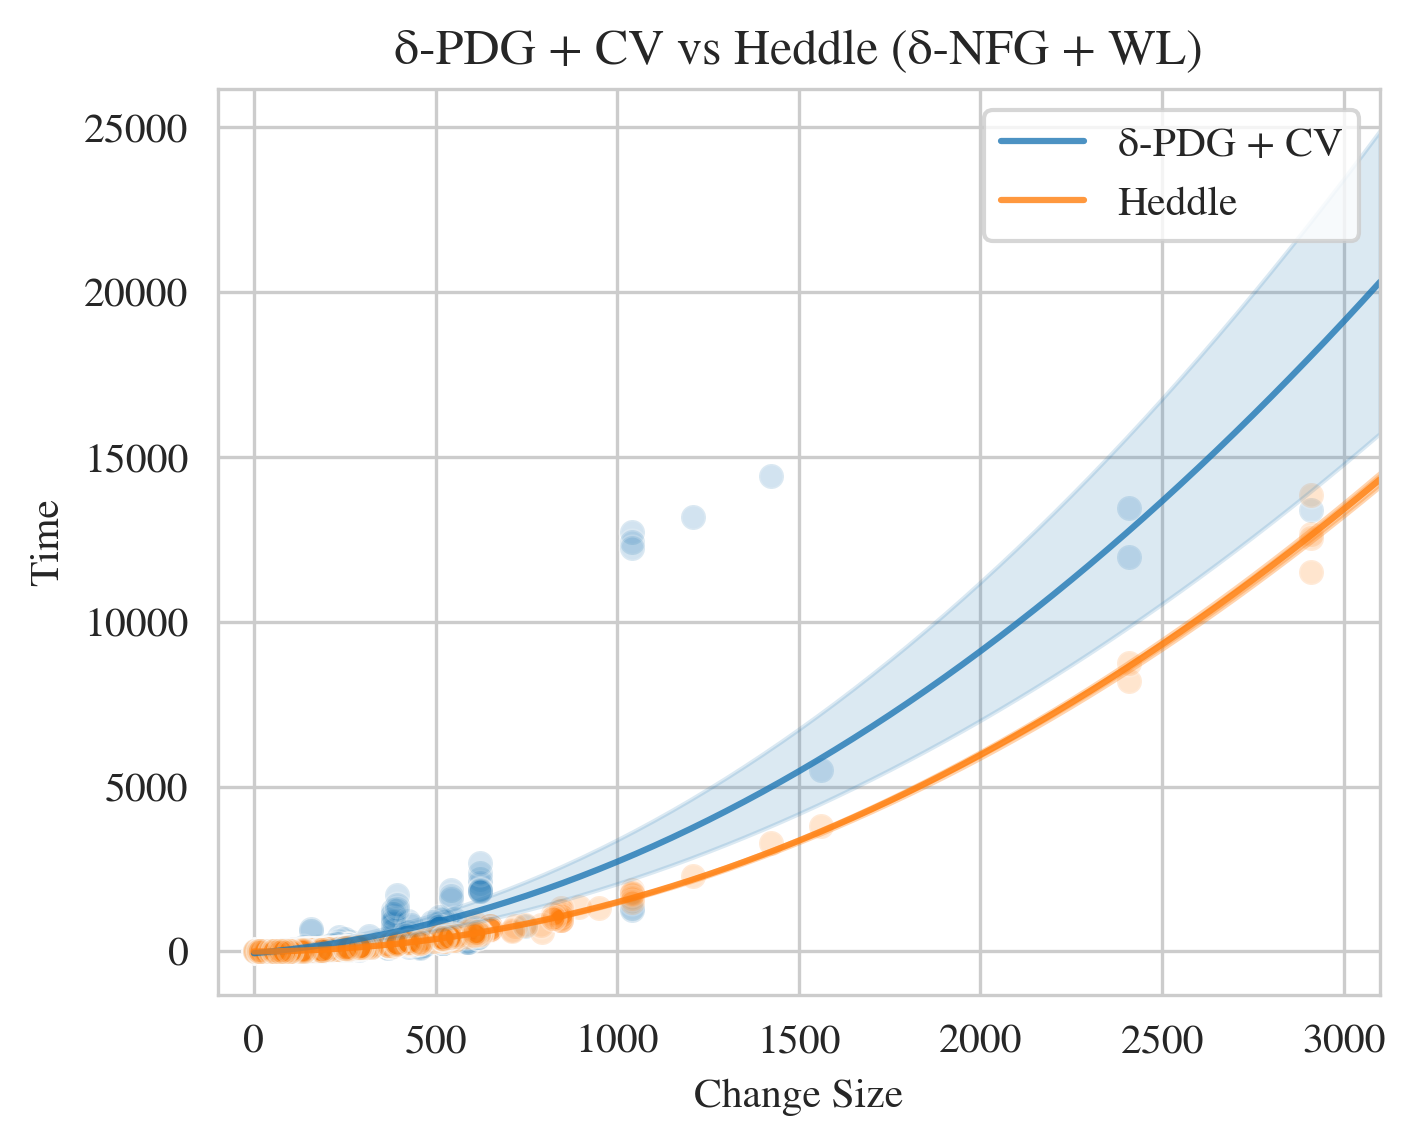

Delta at 500 nodes:
507.9148 seconds
Delta at 1000 nodes:
1226.7057 seconds


In [23]:
if add_graph_size:
    # Normal assumption, z-value for alpha = 0.01
    std = 2.58
    # Also, the biggest change size is just under 3000, so we put the limit close to that
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.gca()
    for m in methods_considered[-2:]:
        sns.scatterplot(data=df[(df.Concepts > 1) & (df.Method == m)], 
                        x="Change Size", y="Time", ax=ax, label=None, alpha=0.2)
    plt.plot(list(np.arange(0, 3101, 50)),
            [herzig_line(x) for x in np.arange(0, 3101, 50)], 
             label="δ-PDG + CV", alpha=0.8, color=sns.color_palette()[0])
    ax.fill_between(list(np.arange(0, 3101, 50)),
                    [herzig_line_minus_sd(x, std) for x in np.arange(0, 3101, 50)],
                    [herzig_line_plus_sd(x, std) for x in np.arange(0, 3101, 50)],
                    alpha=0.16, color=sns.color_palette()[0]
                   )
    plt.plot(list(np.arange(0, 3101, 50)),
            [heddle_line(x) for x in np.arange(0, 3101, 50)], 
             label ="Heddle", alpha=0.8, color=sns.color_palette()[1])
    ax.fill_between(list(np.arange(3101, step=50)),
                    [heddle_line_minus_sd(x, std) for x in np.arange(0, 3101, 50)],
                    [heddle_line_plus_sd(x, std) for x in np.arange(0, 3101, 50)],
                    alpha=0.33, color=sns.color_palette()[1]
                   )
    plt.title("%s vs %s" % tuple(methods_considered[-2:]))
    plt.legend()
    plt.xlim((-100, 3100))
    plt.show()
    print("Delta at 500 nodes:")
    print("%-1.4f seconds" % (herzig_line(500) - heddle_line(500)))
    print("Delta at 1000 nodes:")
    print("%-1.4f seconds" % (herzig_line(1000) - heddle_line(1000)))

In [24]:
if add_graph_size:    
    m = "Heddle (δ-NFG + WL)"
    regression_df = df[df.Method == m]
    mod = rlm(formula="Time ~ Q(\"Change Size\") + I(Q(\"Change Size\") ** 2)", 
              data=regression_df,)
    scale_est = HuberScaleWithRept()
    heddle_result  = mod.fit(scale_est=scale_est)
    print(heddle_result.summary())
    r2_wls = sm.WLS(mod.endog, mod.exog, weights=mod.fit().weights).fit().rsquared
    print("R^2: %2.4f" % r2_wls)
    
    def heddle_line(x):
        return heddle_result.params['Intercept'] \
    + heddle_result.params['Q("Change Size")'] * x \
    + heddle_result.params['I(Q("Change Size") ** 2)'] * x * x
    
    def heddle_line_plus_sd(x, std):
        return heddle_result.params['Intercept'] \
    + heddle_result.params['Q("Change Size")'] * x \
    + heddle_result.params['I(Q("Change Size") ** 2)'] * x * x \
    + std * heddle_result.bse['Intercept'] \
    + std * heddle_result.bse['Q("Change Size")'] * x \
    + std * std * heddle_result.bse['I(Q("Change Size") ** 2)'] * x * x
    
    def heddle_line_minus_sd(x, std):
        return heddle_result.params['Intercept'] \
    + heddle_result.params['Q("Change Size")'] * x \
    + heddle_result.params['I(Q("Change Size") ** 2)'] * x * x \
    - std * heddle_result.bse['Intercept'] \
    - std * heddle_result.bse['Q("Change Size")'] * x \
    - std * std * heddle_result.bse['I(Q("Change Size") ** 2)'] * x * x
    

                    Robust linear Model Regression Results                    
Dep. Variable:                   Time   No. Observations:                 3948
Model:                            RLM   Df Residuals:                     3945
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                HuberScale                                         
Cov Type:                          H1                                         
Date:                Thu, 05 Mar 2020                                         
Time:                        17:43:55                                         
No. Iterations:                    43                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [25]:
if add_graph_size:
    m = "δ-PDG + CV"
    regression_df = df[df.Method == m]
    mod = rlm(formula="Time ~ Q(\"Change Size\") + I(Q(\"Change Size\") ** 2)", 
              data=regression_df)
    scale_est = HuberScaleWithRept()
    herzig_result  = mod.fit(scale_est=scale_est)
    print(herzig_result.summary())
    r2_wls = sm.WLS(mod.endog, mod.exog, weights=mod.fit().weights).fit().rsquared
    print("R^2: %2.4f" % r2_wls)
        
    def herzig_line(x):
        return herzig_result.params['Intercept'] \
    + herzig_result.params['Q("Change Size")'] * x \
    + herzig_result.params['I(Q("Change Size") ** 2)'] * x * x
    
    def herzig_line_plus_sd(x, std):
        return herzig_result.params['Intercept'] \
    + herzig_result.params['Q("Change Size")'] * x \
    + herzig_result.params['I(Q("Change Size") ** 2)'] * x * x \
    + std * herzig_result.bse['Intercept'] \
    + std * herzig_result.bse['Q("Change Size")'] * x \
    + std * std * herzig_result.bse['I(Q("Change Size") ** 2)'] * x * x
    
    def herzig_line_minus_sd(x, std):
        return herzig_result.params['Intercept'] \
    + herzig_result.params['Q("Change Size")'] * x \
    + herzig_result.params['I(Q("Change Size") ** 2)'] * x * x \
    - std * herzig_result.bse['Intercept'] \
    - std * herzig_result.bse['Q("Change Size")'] * x \
    - std * std * herzig_result.bse['I(Q("Change Size") ** 2)'] * x * x
                

                    Robust linear Model Regression Results                    
Dep. Variable:                   Time   No. Observations:                 2352
Model:                            RLM   Df Residuals:                     2349
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                HuberScale                                         
Cov Type:                          H1                                         
Date:                Thu, 05 Mar 2020                                         
Time:                        17:43:56                                         
No. Iterations:                    50                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
if add_graph_size:
    # Normal assumption, z-value for alpha = 0.01
    std = 2.58
    # Also, the biggest change size is just under 3000, so we put the limit close to that
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.gca()
    for m in methods_considered[-2:]:
        sns.scatterplot(data=df[(df.Concepts > 1) & (df.Method == m)], 
                        x="Change Size", y="Time", ax=ax, label=None, alpha=0.2)
    plt.plot(list(np.arange(0, 3101, 50)),
            [herzig_line(x) for x in np.arange(0, 3101, 50)], 
             label="δ-PDG + CV", alpha=0.8, color=sns.color_palette()[0])
    ax.fill_between(list(np.arange(0, 3101, 50)),
                    [herzig_line_minus_sd(x, std) for x in np.arange(0, 3101, 50)],
                    [herzig_line_plus_sd(x, std) for x in np.arange(0, 3101, 50)],
                    alpha=0.16, color=sns.color_palette()[0]
                   )
    plt.plot(list(np.arange(0, 3101, 50)),
            [heddle_line(x) for x in np.arange(0, 3101, 50)], 
             label ="Heddle", alpha=0.8, color=sns.color_palette()[1])
    ax.fill_between(list(np.arange(3101, step=50)),
                    [heddle_line_minus_sd(x, std) for x in np.arange(0, 3101, 50)],
                    [heddle_line_plus_sd(x, std) for x in np.arange(0, 3101, 50)],
                    alpha=0.33, color=sns.color_palette()[1]
                   )
    plt.title("%s vs %s" % tuple(methods_considered[-2:]))
    plt.legend()
    plt.xlim((-100, 3100))
    plt.show()
    print("Delta at 500 nodes:")
    print("%-1.4f seconds" % (herzig_line(500) - heddle_line(500)))
    print("Delta at 1000 nodes:")
    print("%-1.4f seconds" % (herzig_line(1000) - heddle_line(1000)))